In [1]:
import numpy as np
import random
from numpy.linalg import svd, det, norm
from tqdm import tqdm
import matplotlib.pyplot as plt

# Implementation of c-RMSD and d-RMSD

We are given $80$ conformations of a specific molecule in file `80_conformations.dat` with $n = 369$ atoms on the backbone (hence in correspondence). The file starts with $2$ lines containing $80$ and $n$. The rest of the file uses tabs to define $3$ columns containing $n$ triplets $x y z$ of each conformation hence $2 + 80n$ rows.

We read the `80_conformations.dat` file and we store the results in a dictionary where the keys are the conformations and the values are the coordinates of their $369$ atoms. Hence, the dictionary has $80$ keys.

In [22]:
with open('../data/80_conformations.dat', 'r') as file:
    coordinates = []
    for line in file:
        if len(line.strip().split('\t')) == 3 :
            coor = np.zeros(3) 
            for i,value in enumerate(line.strip().split('\t')):
                coor[i] = float(value)
            coordinates.append(coor)

conformations = {}
i = 0
j = 0
while True:
    if i not in conformations:
        conformations[i] = [coordinates[j]]
    else:
        conformations[i].append(coordinates[j])
    j +=1
    if j >= len(coordinates):
        break
    if j%369 == 0:
        i +=1

In [23]:
# conformations

# 2.1 cRMSD

We want to implement an algorithm in order to calculate the c-RMSD between two conformations. The equation for the c-RMSD is as follows:

c-RMSD $ {=} \sqrt {1/n \sum_{i=1}^N \|x_i -y_i\|^2} $

To compute the c-RMSD between two molecules, first we have to align the molecules following these steps:

1. **Perform Translation:** In this step we translate to common origin by subtracting from $\bar{x_i}$'s centroid as follows:

> $ \bar{x_c} = 1/n \sum_{i=1}^N \bar{x_i}$,  $\bar{x_i} \in \mathbb{R^3}$

and subtracting $\bar{y_c}$ from all $\bar{y_i}$'s, $\bar{y_i} \in \mathbb{R^3}$

To implement this step, we create the `translate` function.

In [24]:
def translate(x):
    x_c = np.mean(x, axis=0)
    X = []
    for item in x:
        X.append(np.subtract(item,x_c))
    X = np.array(X)
    return X

2. **Perform Rotation:** In this step we rotate the first conformation by multiplying each coordinate with a $3 \times 3$ rotation matrix $Q : Q^T Q {+} I$.

To that end, we employ the Singular Value Decompotision (SVD) method as follows:

The factorization of $X^\text{T}Y$ is given by $U\Sigma V^\text{T}$. We know that the minimum distance occurs when $V^\text{T}Q^\text{T}U = I \Leftrightarrow Q =  UV^\text{T}$.

If $\det Q = -1$, we take the reflection of $Q$, negating the $3$rd column of $U$ to get $\bar{U}$.

To implement this step, we create the `rotate` function. 

In [25]:
 def rotate(X, Y):
    
    # SVD calculation of U, Σ, V
    U, S, V = svd(X.T @ Y)
    
    # Calculate Q
    Q = U @ V
    
    # Check det
    if det(Q) < 0:
        for i in range(3):
            U[i][2] = U[i][2] * (-1)
        Q = U @ V
        
    return Q

We create the `cRMSD` function that caclulates the c-RMSD between two conformations, afer performing translation and rotation. 

In [26]:
def cRMSD(x, y):
    
    # Translate to common origin
    X = translate(x)
    Y = translate(y)
    
    N = len(X)
    
    # Rotate to optimal alignment
    Q = rotate(X, Y)
    
    # Calculate RMSD
    #RMSD = norm(X @ Q - Y) / np.sqrt(len(x)) # vectorized solution
    sigma = 0
    for i in range(N):
        sigma += norm(X[i] @ Q - Y[i])**2

    cRMSD = np.sqrt(1 / N * sigma)   
    
    return cRMSD 

In [27]:
# Calculate c-RMSD of the first two conformations

x = conformations[0]
y = conformations[1]

cRMSD_12 = cRMSD(x,y)

print('The c-RMSD between the first two conformtations is ' + str(cRMSD_12))

The c-RMSD between the first two conformtations is 0.6271694758794248


# 2.2 Mean Median c-RMSD

Having implemented the c-RMSD, we compute the c-RMSD distance between all $80\choose 2$ to all pairs of conformations, we compute the mean and the median c-RMSD distance and draw a histogram of the resulted distances in $10$ classes (bins).

In [28]:
sum_cRMSD = []

for i in tqdm(range(len(conformations))):
    for j in range(0,i):
        sum_cRMSD.append(cRMSD(conformations[i], conformations[j]))

mean = np.mean(sum_cRMSD)
median = np.median(sum_cRMSD)

print('mean: ' + str(mean))
print('median: ' + str(median))
print(len(sum_cRMSD))

100%|██████████| 80/80 [00:10<00:00,  7.70it/s]

mean: 9.64069626588974
median: 9.635078088307244
3160


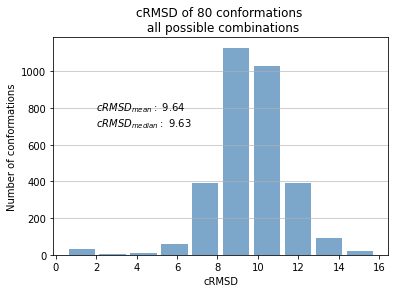

In [29]:
plt.figure()
plt.hist(sum_cRMSD, bins=10, color='steelblue', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('cRMSD')
plt.ylabel('Number of conformations')
plt.title('cRMSD of 80 conformations \n all possible combinations' )
plt.text(2, 700, '$cRMSD_{mean}:$ '+ str(mean)[:4] + '\n' + '$cRMSD_{median}:$ ' + str(median)[:4])
plt.savefig('cRMSD.pdf')
plt.show()

# 2.3 d-RMSD

In order to implement the d-RMSD, first we calculate all the distances within each of the $80$ conformations and store the results in the `conf_dist` dictionary. 

In [30]:
def distances(x):
    d = []
    for i in range(len(x)):
        for j in range(0,i):
            d.append(norm(x[i]-x[j]))
    return d        

In [31]:
conf_dist = {}
for x in tqdm(conformations):
    X = conformations[x]
    conf_dist[x] = distances(X)
    
# print(conf_dist)

100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


We create the d-RMSD function that calculates the RMSD between two conformations, given the distances between the C$_\alpha$ atoms within the conformation.

d-RMSD $ {=} \sqrt {1/k \sum_{i=1}^k (d_i - d_i')^2} $

In [32]:
def dRMSD(x1, x2, k):
    
    # Caclulate dRMSD when all distances are available
    if k == len(x1):
    
        suma = 0
        for i in range(k):
            suma += np.power(x1[i] - x2[i], 2)

        dRMSD = np.sqrt(1 / k * suma)
        
    # Calculate dRMSD when some distances are available    
    else:
        
        suma = 0
        random_indices = random.sample(range(0,len(x1)), k)
        for i in random_indices:
            suma += np.power(x1[i] - x2[i], 2)

        dRMSD = np.sqrt(1 / k * suma)
        
    return dRMSD
    

We calculate the d-RMSD between all pairs of $80$ conformations using all distances within the conformation, as well as a random subset of the distances of size $k=3n$.

In [33]:
# All distances

k_all = len(conf_dist[0])

# Random distances

k_random = 3 * len(conformations[0])

In [34]:
# Calculate RMSD using all distances within its conformation
sumall_dRMSD = []
for i in tqdm(range(len(conformations))):
    for j in range(0,i):
        sumall_dRMSD.append(dRMSD(conf_dist[i], conf_dist[j], k=k_all))
    
mean = np.mean(sumall_dRMSD)
median = np.median(sumall_dRMSD)

print('mean: ' + str(mean))
print('median: ' + str(median))
print(len(sumall_dRMSD))

100%|██████████| 80/80 [07:12<00:00,  5.40s/it]

mean: 6.795032197504436
median: 6.46860694634724
3160


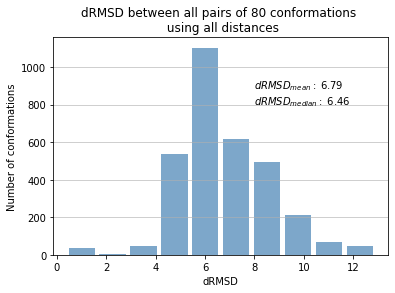

In [35]:
# Histogram of dRMSD when using all distances within its conformation
plt.figure()
plt.hist(sumall_dRMSD, bins=10, color='steelblue', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('dRMSD')
plt.ylabel('Number of conformations')
plt.title('dRMSD between all pairs of 80 conformations \n using all distances')
plt.text(8, 800, '$dRMSD_{mean}:$ '+ str(mean)[:4] + '\n' + '$dRMSD_{median}:$ ' + str(median)[:4])
plt.savefig('dRMSD_all.pdf')
plt.show()

In [36]:
# Calculate RMSD using random subset of distances within its conformation
sumrand_dRMSD = []
for i in tqdm(range(len(conformations))):
    for j in range(0,i):
        sumrand_dRMSD.append(dRMSD(conf_dist[i], conf_dist[j], k=k_random))

mean = np.mean(sumrand_dRMSD)
median = np.median(sumrand_dRMSD)

print('mean: ' + str(mean))
print('median: ' + str(median))
print(len(sumrand_dRMSD))

100%|██████████| 80/80 [00:09<00:00,  8.56it/s]

mean: 6.787887071685775
median: 6.4745781624287755
3160


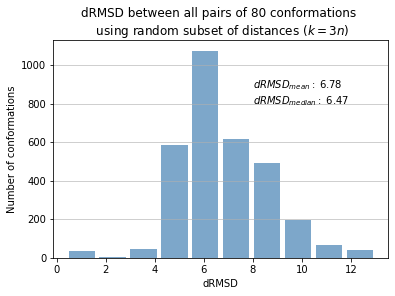

In [37]:
# Histogram of dRMSD when using all distances within its conformation
plt.figure()
plt.hist(sumrand_dRMSD, bins=10, color='steelblue', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('dRMSD')
plt.ylabel('Number of conformations')
plt.title('dRMSD between all pairs of 80 conformations \n using random subset of distances ($k=3n$)' )
plt.text(8, 800, '$dRMSD_{mean}:$ '+ str(mean)[:4] + '\n' + '$dRMSD_{median}:$ ' + str(median)[:4])
plt.savefig('dRMSD_random.pdf')
plt.show()